In [59]:
import argparse
from pathlib import Path
from typing import Tuple
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import MNIST
from tqdm import tqdm
from source import SplitNN, NoPeekLoss

In [2]:
def train_epoch(model, optimiser, criterion, train_loader, device) -> Tuple[float, float]:
    
    train_loss = 0.0
    correct = 0
    total = 0

    model.train()
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        optimiser.zero_grad()

        outputs, intermediates = model(inputs)

        loss = criterion(inputs, intermediates, outputs, targets)
        loss.backward()
        optimiser.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return 100 * correct / total, train_loss

In [3]:
def test(model, test_loader, device) -> float:
    
    correct_test = 0
    total_test = 0

    model.eval()
    for test_inputs, test_targets in test_loader:

        with torch.no_grad():
            outputs, _ = model(test_inputs)

        _, predicted = outputs.max(1)
        total_test += test_targets.size(0)
        correct_test += predicted.eq(test_targets).sum().item()

    return 100 * correct_test / total_test

In [11]:
#Default arguments
parser = argparse.ArgumentParser(description="SplitNN with NoPeek loss")
parser.add_argument("--epochs", default=10, type=int)
parser.add_argument("--batch_size", default=64, type=int)
parser.add_argument("--learning_rate",default=1,type=float)
parser.add_argument("--gamma", default=0.7, type=float)
parser.add_argument("--saveas", default="nopeek", type=str)
parser.add_argument("--n_train_data",default=10000,type=int)
args = parser.parse_args("")

In [5]:
project_root = Path.cwd().resolve()
project_root

WindowsPath('C:/Users/akgo1/CS 498/Project')

In [35]:
if __name__ == "__main__":
    
    #Weight for privacy preserving part of loss function
    
    weighting = 0.15

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    #Directories for saving

    project_root = Path.cwd().resolve()
    data_dir = project_root / "data"
    root_model_path = project_root / "models"
    model_name = args.saveas + f"_{weighting}weight".replace(".", "_")
    MODEL_SAVE_PATH = (root_model_path / model_name).with_suffix(".pth")

    summary_writer_path = project_root / "models" / ("tb_" + model_name)

    # Model
    model = SplitNN()
#     model = model.to(DEVICE)
    model.train()

    # Data
    data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]
    )
    
    train_data = MNIST(data_dir, download=True, train=True, transform=data_transform)

    # Train data - 10000 points
    train_data.data = train_data.data[: args.n_train_data]
    train_data.targets = train_data.targets[: args.n_train_data]

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=args.batch_size)

    # Test data
    test_data = MNIST(data_dir, download=True, train=False, transform=data_transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024)

    # Training phase
    n_epochs = args.epochs

    best_accuracy = 0.0

    writer = SummaryWriter(summary_writer_path)

    criterion = NoPeekLoss(weighting)

    optimiser = optim.Adadelta(model.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=args.gamma)

    epoch_pbar = tqdm(total=n_epochs)

    print("Starting training...")
    
    train_acc_list = []
    test_acc_list = []
    
    for epoch in range(n_epochs):
        
        train_acc, train_loss = train_epoch(model, optimiser, criterion, train_loader, DEVICE)
        test_acc = test(model, test_loader, DEVICE)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        # Update learning rate
        scheduler.step()

        # Update tensorboard
        writer.add_scalars("Accuracy", {"train": train_acc, "test": test_acc}, epoch)
        writer.add_scalar("Loss/train", train_loss, epoch)

        # Update model if accuracy is higher
        if test_acc > best_accuracy:
            best_accuracy = test_acc

            state_dict = {
                "model_state_dict": model.state_dict(),
                "epoch": epoch,
                "train_acc": train_acc,
                "test_acc": test_acc,
            }
            
            torch.save(state_dict, MODEL_SAVE_PATH)

        # Update prog bar
        epoch_pbar.set_description(
            f"Training {train_acc: .2f}%; "
            f"Test {test_acc : .2f}%; "
            f"Best test {best_accuracy : .2f}%"
        )
        epoch_pbar.update(1)

    epoch_pbar.close()
    writer.close()

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Starting training...


Training  68.38%; Test  65.61%; Best test  65.61%: 100%|███████████████████████████████| 10/10 [11:34<00:00, 69.48s/it]


In [40]:
train_acc_list

[43.36, 42.03, 49.16, 54.56, 59.59, 63.36, 65.43, 66.77, 67.66, 68.38]

In [41]:
test_acc_list

[40.85, 50.19, 53.24, 57.18, 61.04, 63.05, 64.32, 65.05, 65.32, 65.61]

In [73]:
train_list = {0: [71.28, 93.68, 96.1, 97.05, 97.66, 97.91, 98.14, 98.26, 98.35, 98.4],
              0.01: [72.41, 93.5, 95.72, 96.89, 97.74, 98.12, 98.36, 98.5, 98.61, 98.72],
              0.05: [61.27, 86.46, 92.18, 94.59, 95.91, 96.62, 97.11, 97.42, 97.59, 97.7],
              0.1: [45.05, 68.19, 78.32, 88.68, 91.6, 92.93, 93.95, 94.57, 95.08, 95.39],
              0.15: [43.36, 42.03, 49.16, 54.56, 59.59, 63.36, 65.43, 66.77, 67.66, 68.38],
              0.2: [34.25, 23.28, 30.63, 32.84, 33.96, 36.75, 39.12, 40.43, 41.16, 41.66]    
             }
weights = [0, 0.01, 0.05, 0.1, 0.15, 0.2]
test_list = {0: [88.34, 94.29, 95.44, 96.4, 96.82, 96.86, 97.01, 97.05, 97.04, 97.02],
             0.01: [92.15, 92.87, 93.9, 94.43, 95.22, 95.45, 95.63, 95.79, 95.97, 95.95],
             0.05: [76.38, 89.74, 91.82, 92.91, 93.22, 93.6, 93.95, 94.18, 94.35, 94.31],
             0.1: [61.44, 73.17, 84.47, 87.94, 90.51, 91.03, 91.68, 91.88, 92.02, 92.06],
             0.15: [40.85, 50.19, 53.24, 57.18, 61.04, 63.05, 64.32, 65.05, 65.32, 65.61],
             0.2: [24.31, 26.78, 32.19, 32.48, 34.1, 36.24, 37.83, 38.29, 38.51, 38.75]            
            }
epochs = np.arange(1,11)
colors = ['black', 'red', 'darkgreen', 'blue', 'orange', 'yellow']

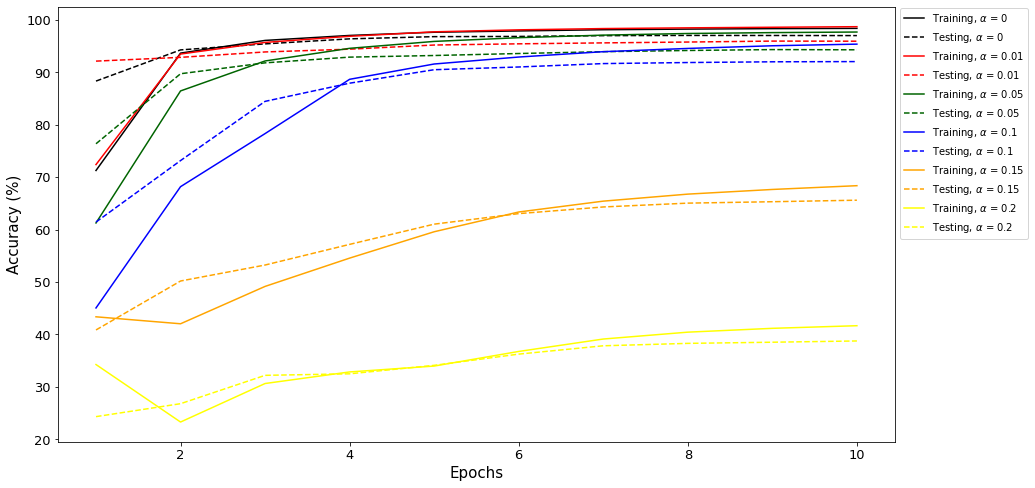

In [92]:
fig = plt.figure(figsize=(15, 8))
for j, i in enumerate(weights):
    plt.plot(epochs, train_list[i], color=colors[j], label = r"Training, $\alpha$ = " + str(i))
    plt.plot(epochs, test_list[i], color=colors[j], linestyle='dashed', label = r"Testing, $\alpha$ = " + str(i))
plt.legend()
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Accuracy (%)', fontsize = 15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(bbox_to_anchor=(1, 1.01))
plt.show()